In [1]:
import json
import pandas as pd
import numpy as np
import os
import time
#import progressbar
from numpy.lib import stride_tricks
map_base_dir = './'
map_img_dir = './train/images/'

In [2]:
!pip install mahotas 

In [3]:
import cv2
from matplotlib.path import Path
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from skimage import feature
from skimage.color import label2rgb
from skimage.io import imread
import mahotas as mt

In [4]:
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        #c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

In [5]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle

In [6]:
#load anotation json file 
json_path = os.path.join(map_base_dir, 'annotation-small.json') 
with open(json_path, 'r') as f:
    annot_data = json.load(f)

In [7]:
annot_data['images'][:3]#to understand the annotation

[{'id': 232566, 'file_name': '000000232566.jpg', 'width': 300, 'height': 300},
 {'id': 160847, 'file_name': '000000160847.jpg', 'width': 300, 'height': 300},
 {'id': 1457, 'file_name': '000000001457.jpg', 'width': 300, 'height': 300}]

In [8]:
image_df = pd.DataFrame(annot_data['images'])
image_df[:3]

,id,file_name,width,height
0,232566,000000232566.jpg,300,300
1,160847,000000160847.jpg,300,300
2,1457,000000001457.jpg,300,300


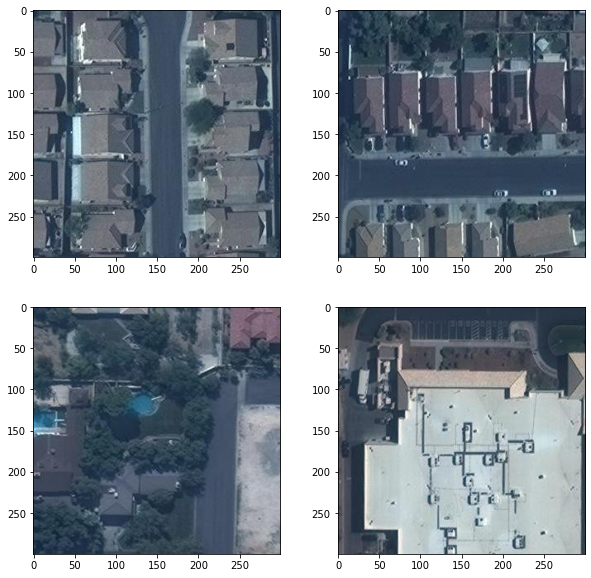

In [9]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [10]:
image_df[:3]

,id,file_name,width,height
0,232566,000000232566.jpg,300,300
1,160847,000000160847.jpg,300,300
2,1457,000000001457.jpg,300,300


In [11]:
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df[:3]

,id,image_id,segmentation,area,bbox,category_id,iscrowd
0,585133,68701,"[[191.0, 95.0, 191.0, 28.999999999999996, 214....",2646.0,"[28.999999999999996, 191.0, 209.0, 47.0]",100,0
1,1792841,210291,"[[49.0, -6.184466335694134e-15, 58.0, 10.99999...",3055.0,"[-6.184466335694134e-15, 0.0, 74.0, 61.0]",100,0
2,608388,71375,"[[186.0, 36.0, 222.0, 37.00000000000001, 222.0...",2666.0,"[36.0, 186.0, 223.0, 73.0]",100,0


In [12]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
full_df[:3]

,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
0,585133,68701,"[[191.0, 95.0, 191.0, 28.999999999999996, 214....",2646.0,"[28.999999999999996, 191.0, 209.0, 47.0]",100,0,68701,000000068701.jpg,300,300
1,1792841,210291,"[[49.0, -6.184466335694134e-15, 58.0, 10.99999...",3055.0,"[-6.184466335694134e-15, 0.0, 74.0, 61.0]",100,0,210291,000000210291.jpg,300,300
2,608388,71375,"[[186.0, 36.0, 222.0, 37.00000000000001, 222.0...",2666.0,"[36.0, 186.0, 223.0, 73.0]",100,0,71375,000000071375.jpg,300,300


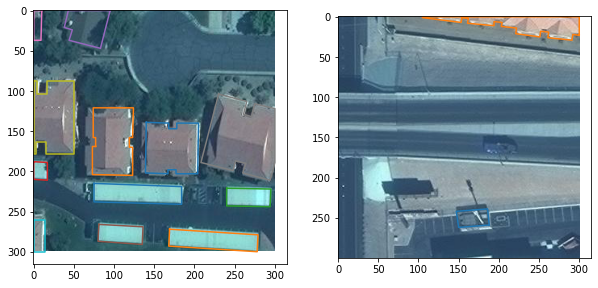

In [13]:
fig, m_axs = plt.subplots(1, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1])

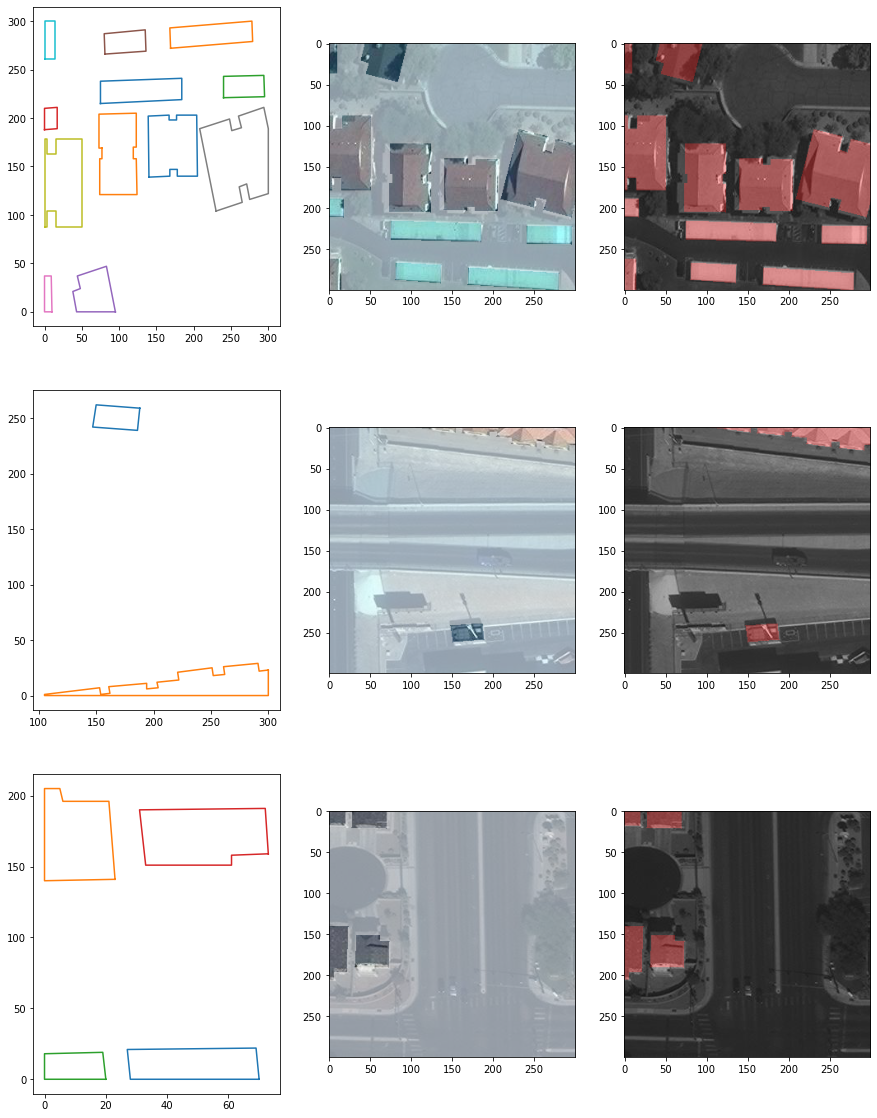

In [50]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    #c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    #d_ax.imshow(out_img)
    #f_ax.imshow(img_data)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))
    
    

In [15]:
train_ids, valid_ids = train_test_split(image_df['id'], test_size = 0.25)
train_df = full_df[full_df['image_id'].isin(train_ids)]
valid_df = full_df[full_df['image_id'].isin(valid_ids)]
print(train_df.shape[0], 'training boxes')
print(valid_df.shape[0], 'validation boxes')

53939 training boxes
17932 validation boxes


In [16]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby('image_id'))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img)>=batch_size:
                yield (np.stack(out_img, 0)/255.0).astype(np.float32), np.stack(out_seg, 0).astype(np.float32)
                out_img, out_seg = [], []
valid_gen = batch_img_gen(valid_df, 1)          

In [17]:
imgs_train = []
label_train = []
i=0
while i<40:
    t_x, t_y = next(valid_gen)
  
    imgs_train.append((np.array(t_x[0])*255).astype(np.uint8))
    label_train.append(np.array(t_y[:, :, :, 0][0]).astype(int))
    i=i+1

D:\education\bbbb\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Showing the orginal data:


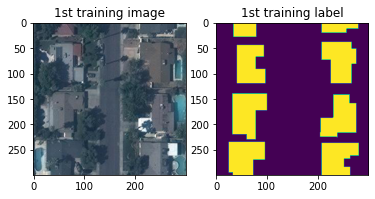

In [18]:

# show the original images
print('Showing the orginal data:')
f, ax = plt.subplots(1,2)
ax[0].imshow(imgs_train[2])
ax[0].set_title('1st training image')
ax[1].imshow(label_train[2])
ax[1].set_title('1st training label')
plt.show()


In [19]:
imgs_test = []
num=0
while num<2:
    t_x, t_y = next(valid_gen)
    imgs_test.append((np.array(t_x[0])*255).astype(np.uint8))
    num=num+1
    

In [20]:
#improved
def extract_features(img, img_gary, label, train, lbp_radius = 10, lbp_points_ratio = 4, h_neighbors = 11, num_examples = 100):
  '''
  extract above 13 features
  '''

  #1.  RGB values have beed extracted when loading the orignal dataset --img--
  #2.  Local Binary Pattern https://www.researchgate.net/figure/Local-binary-patterns-LBP-texture-a-Principle-of-LBP-b-LBP-texture-of-the-canopy_fig4_323741245
  def LBP(img,points,radius):
    '''
     points: Number of circularly symmetric neighbour set points 
     radius: Radius of circle
    '''
    #print(' extracting local binary pattern features.')
    lbp = feature.local_binary_pattern(img, points, radius)
    return (lbp-np.min(lbp))/(np.max(lbp)-np.min(lbp)) * 255
  
  #3. Haralick's texture features https://gogul.dev/software/texture-recognition
  #https://www.dovepress.com/application-of-haralick-texture-features-in-brain-18f-florbetapir-posi-peer-reviewed-fulltext-article-CIA
  def HTF(img, h_neighbors, ss_dix):
    '''
    h_neighbors:
    '''
    #print(' extracting haralick texture features.')
    size = h_neighbors
    shape = (img.shape[0] - size + 1, img.shape[1] - size + 1, size, size)
    # should be equal to the size of feature_img = feature_img[h_index:-h_index, h_index:-h_index]
    strides = 2 * img.strides
    patches = stride_tricks.as_strided(img, shape=shape, strides = strides)
    patches = patches.reshape(-1,size,size)
    
    if len(ss_idx) == 0:
      bar = progressbar.ProgressBar(maxval = len(patches), \
                                   widgets = [progressbar.Bar('=','[', ']'), ' ', progressbar.Percentage()])
    else:
      bar = progressbar.ProgressBar(maxval=len(ss_idx), \
        widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    
    
    def calculate_haralick(img):
      '''
      calculate haralick features for each patch
      '''
      features = []
      
      feature_ = mt.features.haralick(img)
      mean_ = feature_.mean(axis=0)
      
      [features.append(i) for i in mean_[0:9]]
      
      return np.array(features)
    
   
    bar.start()
    h_features = []
    
    if len(ss_idx) == 0:
      for i, p in enumerate(patches):
        bar.update(i+1)
        h_features.append(calculate_haralick(p))
    else:
      for i, p in enumerate(patches[ss_idx]):
        bar.update(i+1)
        h_features.append(calculate_haralick(p))
    
    return np.array(h_features)
  
  
  #4. extracting all the features
  
  # Hyperparameters:
  lbp_points = lbp_radius*lbp_points_ratio # number of circularly symmetric neighbour set points 
  
  
  #num_examples = 1000 # number of examples (pixels) per image to use for training model
  h_index = int((h_neighbors -1)/2)
  feature_img = np.zeros((img.shape[0], img.shape[1],4))
  feature_img[:,:,:3] = img
  feature_img[:,:,3] = LBP(img_gary, lbp_points, lbp_radius)
  feature_img = feature_img[h_index:-h_index, h_index:-h_index]
  s = feature_img.shape
  features = feature_img.reshape((s[0]*s[1], s[2]))
  
  if train:
    ss_idx = np.random.randint(0,features.shape[0],num_examples)
    features = features[ss_idx]
  else:
    ss_idx = []
  
  h_features = HTF(img_gary, h_neighbors, ss_idx)
  features = np.hstack((features, h_features))
  
  if train:
    label = label[h_index:-h_index, h_index:-h_index]
    labels = label.reshape(label.shape[0]*label.shape[1],1)
    labels = labels[ss_idx]
  else:
    labels = None
 
  return features, labels


In [21]:
def generate_training_data(imgs_train, label_train, train,
                           lbp_radius = 10, lbp_points_ratio = 4,
                           h_neighbors = 11, num_examples = 100):
  start_time = time.time()  
  print("_"*30)
  print("[INFO] Extracting features from original image(s)")
  
  Features = []
  Labels = []
  
  for i, img in enumerate(imgs_train):
    img_gary = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    features, labels = extract_features(img,img_gary,label_train[i], train = train,
                                        lbp_radius = 10, lbp_points_ratio = 4,
                                        h_neighbors = 11, num_examples = 100)
    Features.append(features)
    Labels.append(labels)
    
  Features = np.array(Features)
  s = Features.shape
  Features = Features.reshape((s[0]*s[1],s[2]))
  Labels = np.array(Labels)
  s = Labels.shape
  Labels = Labels.reshape((s[0]*s[1],s[2]))
  Labels = Labels.ravel()
  Labels[Labels==255] =1
  
  print("_"*30)
  print("[INFO] check the size of generated training data")
  print('size of the feature vector: {}'.format(Features.shape))
  print('size of the label vertor: {}'.format(Labels.shape))
  end_time = time.time()
  print('Extracting features time: %.4f s' %(end_time-start_time))
  #np.save('drive/data/X.npy',Features)
  #np.save('drive/data/Y.npy', Labels)
  
  return Features, Labels

In [22]:
!pip install progressbar

In [23]:
import progressbar

In [24]:
X, Y = generate_training_data(imgs_train, label_train, train=True)

______________________________
[INFO] Extracting features from original image(s)


______________________________
[INFO] check the size of generated training data
size of the feature vector: (4000, 13)
size of the label vertor: (4000,)
Extracting features time: 54.1400 s


In [25]:

def train(train_X, train_Y, classifier):
  
  start_time = time.time()
  
  if classifier == "SVM":
    print("_"*30)
    print ('[INFO] Training a Support Vector Machine model.')
    model = SVC(kernel = 'linear')
  elif classifier == "RF":
    print("_"*30)
    print('[INFO] Training a Random Forest model.')
    model = RandomForestClassifier(n_estimators=15, criterion = 'entropy', max_features = 'auto',
                                     max_depth=8, min_samples_split = 3, min_samples_leaf = 18, random_state=42, bootstrap = 'True')
  elif classifier == "DT":
    print("_"*30)
    print('[INFO] Training a Decision Tree model.')
    model = DecisionTreeClassifier(criterion = "gini",
            random_state = 100,max_depth=3, min_samples_leaf=5)
    
    
  model.fit(train_X, train_Y)
    
  end_time = time.time()

  
  print("_"*30)
  print('[INFO] Training complete.')
  print('training time: %.4f s' %(end_time-start_time))
  
  return model


In [26]:
train_X, test_X, train_Y, test_Y = train_test_split(X,Y,test_size=0.3, random_state=42) 

In [27]:
#model_SVM = train(train_X, train_Y, classifier='SVM')

In [28]:
model_RF = train(train_X, train_Y, classifier='RF')

______________________________
[INFO] Training a Random Forest model.
______________________________
[INFO] Training complete.
training time: 0.1950 s


In [29]:
model_SVM = train(train_X, train_Y, classifier='SVM')

______________________________
[INFO] Training a Support Vector Machine model.
______________________________
[INFO] Training complete.
training time: 453.4572 s


In [30]:
model_DT = train(train_X, train_Y, classifier='DT')

______________________________
[INFO] Training a Decision Tree model.
______________________________
[INFO] Training complete.
training time: 0.0215 s


In [31]:
def test(test_X, test_Y,model_used):
  
  

    pred = model_used.predict(test_X)
    precision = metrics.precision_score(test_Y, pred, average='binary', labels=np.unique(pred))
    accuracy = metrics.accuracy_score(test_Y, pred)
    print ('_'*30)
    print('[RESULTS] Testing...')
    print ('Accuracy: %.4f' %accuracy)
    print ('Precision: %.4f' %precision)
    
 


In [32]:
test(test_X, test_Y,model_RF)


______________________________
[RESULTS] Testing...
Accuracy: 0.8233
Precision: 0.8131


In [33]:
test(test_X, test_Y,model_SVM)

______________________________
[RESULTS] Testing...
Accuracy: 0.8067
Precision: 0.7901


In [34]:
test(test_X, test_Y,model_DT)

______________________________
[RESULTS] Testing...
Accuracy: 0.8092
Precision: 0.7273


In [35]:
filename = './RF_model_100_live.pkl'
with open(filename, 'wb') as file:  
    pickle.dump(model_RF, file)

In [36]:
pkl_filename = './RF_model_1000.pkl'
with open(pkl_filename, 'rb') as file:  
    loaded_model_RF = pickle.load(file)

D:\education\bbbb\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
D:\education\bbbb\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [37]:
test(test_X, test_Y,loaded_model_RF)

______________________________
[RESULTS] Testing...
Accuracy: 0.8150
Precision: 0.7209


In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def inference(imgs_test, h_neighbors,classifier):
  start_time = time.time()

  print("_"*30)
  print('[INFO] Doing inference on test images...')
  print('loading trained model.')
  
  border = int((h_neighbors-1)/2)
  Feature = []
  img_list=[]
  print('infer for each image')
  model=classifier
  for img in imgs_test:
    img = cv2.copyMakeBorder(img, top=border, bottom=border, \
                                  left=border, right=border, \
                                  borderType = cv2.BORDER_CONSTANT, \
                                  value=[0, 0, 0])

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    features, _ = extract_features(img, img_gray, label=None, train=False)
    Feature.append(features)
    
   
    
    prediction = model.predict(features.reshape((-1, features.shape[1])))
    size_pred = int(math.sqrt(features.shape[0]))
    pred_img = prediction.reshape(size_pred, size_pred)
    img_list.append(pred_img)
    
     

  end_time = time.time() 
  print('predection time: %.4f s' %(end_time-start_time)) 
    
  return img_list


In [39]:
pred_rf=inference(imgs_test, h_neighbors = 11,classifier=model_RF)

______________________________
[INFO] Doing inference on test images...
loading trained model.
infer for each image


predection time: 1349.9900 s


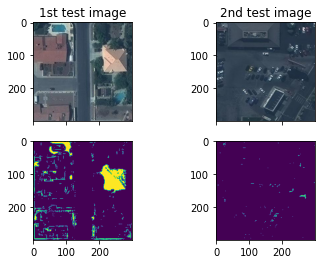

In [40]:
f, ax = plt.subplots(2,2, sharex=True)
ax[0,0].imshow(imgs_test[0])
ax[0,0].set_title('1st test image')
ax[1,0].imshow(pred_rf[0])
ax[0,1].imshow(imgs_test[1])
ax[0,1].set_title('2nd test image')
ax[1,1].imshow(pred_rf[1])


plt.show()

In [41]:
pred_train=inference(imgs_train[:1], h_neighbors = 11,classifier=loaded_model_RF)

______________________________
[INFO] Doing inference on test images...
loading trained model.
infer for each image


KeyboardInterrupt: 

In [ ]:
pred_dt=inference(imgs_test, h_neighbors = 11,classifier=model_DT)

In [ ]:
f, ax = plt.subplots(2,2, sharex=True)
ax[0,0].imshow(imgs_test[0])
ax[0,0].set_title('1st test image')
ax[1,0].imshow(pred_dt[0])
ax[0,1].imshow(imgs_test[1])
ax[0,1].set_title('2nd test image')
ax[1,1].imshow(pred_dt[1])

plt.show()

In [ ]:
pred_dt=inference(imgs_test, h_neighbors = 11,classifier=model_SVM)

In [ ]:
f, ax = plt.subplots(2,2, sharex=True)
ax[0,0].imshow(imgs_test[0])
ax[0,0].set_title('1st test image')
ax[1,0].imshow(pred_dt[0])
ax[0,1].imshow(imgs_test[1])
ax[0,1].set_title('2nd test image')
ax[1,1].imshow(pred_dt[1])

plt.show()